In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline

In [14]:
import sys
sys.path.append('/home/courtney/voxelmorph/src')
import nibabel as nib
from neuron.plot import slices
import numpy as np
import scipy.io as sio
sys.path.append('../ext/medipy-lib')
from medipy.metrics import dice
import datagenerators
from neuron.plot import slices
from pynd.segutils import seg_overlay, seg_overlap
import matplotlib.pyplot as plt


In [32]:
test_brain_file = open('../src/val_files.txt')
test_brain_strings = test_brain_file.readlines()
test_brain_strings = [x.strip() for x in test_brain_strings]
n_batches = len(test_brain_strings)
good_labels = sio.loadmat('../data/labels.mat')['labels'][0]

# atlas_filename = '../t2_atlas_027_S_2219.nii'
# atlas_seg_filename = '../t2_atlas_seg_027_S_2219.nii'
atlas_seg_filename = '../t1_atlas_seg.nii'

# atlas_n_filename = '../t2_atlas_n_027_S_2219.nii'
atlas_n_filename = '../t1_atlas.nii'

# atlas_vol = nib.load(atlas_filename).get_data()
# atlas_seg = nib.load(atlas_seg_filename).get_data()
# nii = nib.Nifti1Image(atlas_vol/np.max(atlas_vol), np.eye(4))
# nib.save(nii, atlas_n_filename)

In [36]:
vol_names = ['t1_027_S_2245_470409', 't1_032_S_5289_427834', 't1_032_S_4277_416034', 't1_027_S_4919_451350', 't1_027_S_4869_451370', 't1_018_S_2155_468860']
n_test = 1
dices = []
for step in range(n_test):
    vol_name = '../images/' + vol_names[step] + '.nii'
    seg_name = '../images/' + vol_names[step] + '_seg.nii'
#     X_vol, X_seg = datagenerators.load_example_by_name(vol_name, seg_name)
    # compute mi-based warping from t1 to t2
    !/data/vision/polina/shared_software/ANTS/build/bin/ANTS 3 -m MI[{atlas_n_filename},{vol_name},1,12] -t Syn[0.25] -o /home/courtney/voxelmorph/ants --number-of-affine-iterations 0 -i 201x201x201 -r Gauss[9,0.2]
    # apply warping on t1 segmentation
    !/data/vision/polina/shared_software/ANTS/build/bin/WarpImageMultiTransform 3 {seg_name} {'../test_seg_%d.nii'%step} -R {atlas_n_filename} /home/courtney/voxelmorph/antsWarp.nii.gz --use-NN
    # apply warping on t1 vol, in case needed for debugging
    !/data/vision/polina/shared_software/ANTS/build/bin/WarpImageMultiTransform 3 {vol_name} {'../test_%d.nii'%step} -R {atlas_n_filename} /home/courtney/voxelmorph/antsWarp.nii.gz

    test_seg = nib.load('../test_seg_%d.nii'%step).get_data()
    vals, _ = dice(atlas_seg, test_seg, labels=good_labels, nargout=2)
    dices.append(vals)

 Run Reg 
 values 1
  Fixed image file: ../t1_atlas.nii
  Moving image file: ../images/t1_027_S_2245_470409.nii
Metric 0:  Not a Point-set
  Fixed image file: ../t1_atlas.nii
  Moving image file: ../images/t1_027_S_2245_470409.nii
  similarity metric weight: 1
  Radius: [12, 12, 12]
  radius: [12, 12, 12]
Use identity affine transform as initial affine para.
aff_init.IsNull()==1
Use identity affine transform as initial fixed affine para.
fixed_aff_init.IsNull()==1
Continue affine registration from the input
affine_opt.use_rotation_header = 0
affine_opt.ignore_void_orgin = 0
transform_initial: IsNotNull():0
OptAffine: metric_type=AffineWithMutualInformation
MI_bins=32 MI_samples=32000
number_of_seeds=0 time_seed=1552423585
number_of_levels=1
number_of_iteration_list=[0]
graident_scales=[1,1,1,1,1,1,1,1,1,1,0.0001,0.0001,0.0001]
is_rigid = 0
mask null: 1
maximum_step_length=0.1
relaxation_factor=0.5
minimum_step_length=0.0001
translation_scales=0.0001
opt.transform_initial.IsNull(): 1
 o

In [ ]:
/data/vision/polina/shared_software/ANTS/build/bin/ANTS 3 -m MI[/home/courtney/voxelmorph/t2_atlas_n_027_S_2219.nii,/home/courtney/voxelmorph/images/t1_027_S_2245_470409.nii,1,48] -t Syn[0.25] -o /home/courtney/voxelmorph/ants --number-of-affine-iterations 0 -i 201x201x201 -r Gauss[9,0.2]
/data/vision/polina/shared_software/ANTS/build/bin/WarpImageMultiTransform 3 /home/courtney/voxelmorph/images/t1_027_S_2245_470409_seg.nii ../test_seg.nii -R /home/courtney/voxelmorph/t2_atlas_n_027_S_2219.nii /home/courtney/voxelmorph/antsWarp.nii.gz --use-NN
/data/vision/polina/shared_software/ANTS/build/bin/WarpImageMultiTransform 3 /home/courtney/voxelmorph/images/t1_027_S_2245_470409.nii /home/courtney/voxelmorph/test.nii -R /home/courtney/voxelmorph/t2_atlas_n_027_S_2219.nii /home/courtney/voxelmorph/antsWarp.nii.gz



In [10]:
def visualize_seg(vol, seg, region_numbers=[4], slice_idx=[80, 90, 110], title=''):
    if title != '':
        title += ', '
    normalized_vol = vol/np.max(vol)
    seg_one_region = np.zeros(seg.shape)
    for num in region_numbers:
        seg_one_region[seg==num] = num
#     seg_one_region[seg_one_region!=0.5] = 0
#     seg_one_region[seg_one_region==0.5] = 1
    img = seg_overlay(normalized_vol, seg_one_region.astype(np.int))
    plt.figure(figsize=(20,10))
    slices([img[slice_idx[0], :, :, :], img[:, slice_idx[1], :, :], img[:, :, slice_idx[2], :]], titles=[title+'x=%d'%slice_idx[0], title+'y=%d'%slice_idx[1], title+'z=%d'%slice_idx[2]])

In [21]:
test_seg = nib.load('../test_seg_%d.nii'%step).get_data()
vals, _ = dice(atlas_seg, seg, labels=good_labels, nargout=2)
print(vals)
print(np.mean(vals))

[0.56443812 0.41641235 0.48282625 0.60129671 0.63990387 0.62423725
 0.63248069 0.57177788 0.45913587 0.44421218 0.26927083 0.73726138
 0.47185652 0.46752535 0.24426534 0.52059701 0.08378718 0.56220939
 0.43828917 0.5984116  0.65491031 0.67137913 0.56028462 0.52267075
 0.58725409 0.41744864 0.52532562 0.63115739 0.49921962 0.11229091]
0.5004045339983542


In [22]:
vol = nib.load(vol_name).get_data()
seg = nib.load(seg_name).get_data()

vals, _ = dice(atlas_seg, test_seg, labels=good_labels, nargout=2)
print(vals)
print(np.mean(vals))

[0.58032766 0.43267983 0.48282625 0.60342672 0.65504851 0.62423725
 0.63248069 0.57177788 0.45913587 0.44971037 0.26175214 0.65019665
 0.48534011 0.47309991 0.24426534 0.52542578 0.0838223  0.57017554
 0.43063489 0.5984116  0.63192905 0.66934034 0.56028462 0.52267075
 0.58871585 0.41744864 0.53600524 0.64126712 0.5039818  0.11177586]
0.4999398189746183


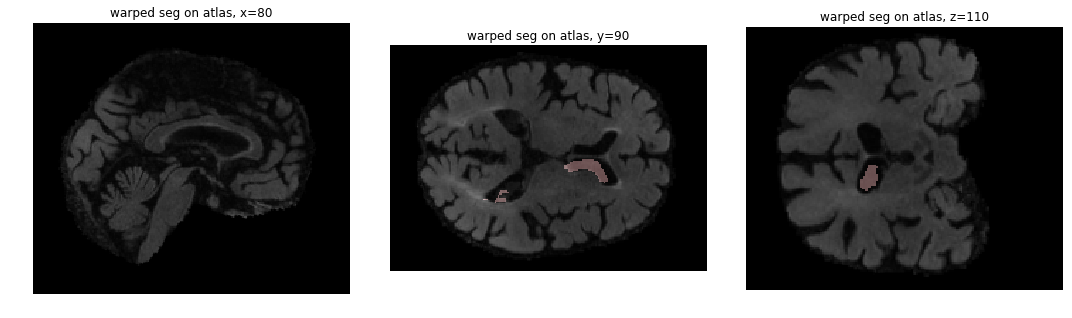

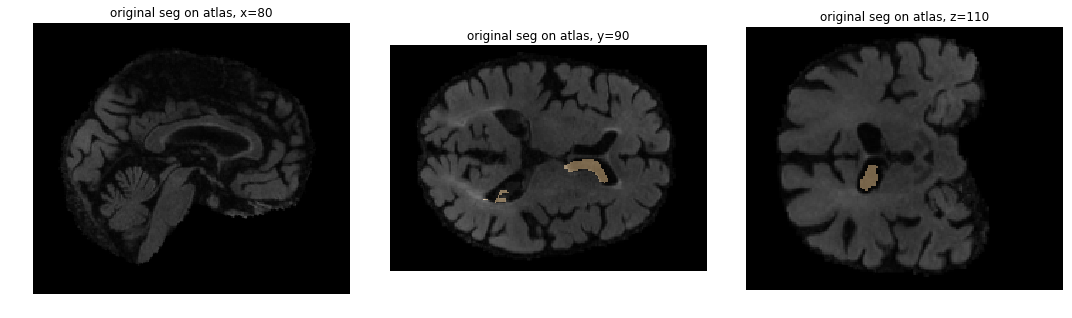

In [25]:
test_seg = nib.load('../test_seg_%d.nii'%step).get_data()
test = nib.load('../test_%d.nii'%step).get_data()
seg = nib.load(seg_name).get_data()
vol = nib.load(vol_name).get_data()

visualize_seg(atlas_vol, test_seg, region_numbers=[4], title='warped seg on atlas')
visualize_seg(atlas_vol, seg, region_numbers=[4], title='original seg on atlas')

In [ ]:
print(dices)
print(np.mean(np.array(dices), axis=0))

In [38]:
print(np.mean(np.array(dices)))

0.5030428087708702


In [40]:
vol_names = ['t1_027_S_2245_470409', 't1_032_S_5289_427834', 't1_032_S_4277_416034', 't1_027_S_4919_451350', 't1_027_S_4869_451370', 't1_018_S_2155_468860']
n_test = 1
new_dices = []
for step in range(n_test):
    vol_name = '../' + vol_names[step] + '.nii'
    seg_name = '../' + vol_names[step] + '_seg.nii'
#     X_vol, X_seg = datagenerators.load_example_by_name(vol_name, seg_name)
    # compute mi-based warping from t1 to t2
    !/data/vision/polina/shared_software/ANTS/build/bin/ANTS 3 -m MI[{atlas_n_filename},{vol_name},1,48] -t Syn[0.25] -o /home/courtney/voxelmorph/ants --number-of-affine-iterations 201x201x201 -i 201x201x201 -r Gauss[9,0.2]
    # apply warping on t1 segmentation
    !/data/vision/polina/shared_software/ANTS/build/bin/WarpImageMultiTransform 3 {seg_name} '../test_seg.nii' -R {atlas_n_filename} /home/courtney/voxelmorph/antsWarp.nii.gz --use-NN
    # apply warping on t1 vol, in case needed for debugging
    !/data/vision/polina/shared_software/ANTS/build/bin/WarpImageMultiTransform 3 {vol_name} '../test.nii' -R {atlas_n_filename} /home/courtney/voxelmorph/antsWarp.nii.gz

    test_seg = nib.load('../test_seg.nii').get_data()
    vals, _ = dice(atlas_seg, test_seg, labels=good_labels, nargout=2)
    new_dices.append(vals)
    print(vals)
    print(np.mean(vals))

 Run Reg 
 values 1
  Fixed image file: ../t2_atlas_n_027_S_2219.nii
  Moving image file: ../t1_027_S_2245_470409.nii
Metric 0:  Not a Point-set
  Fixed image file: ../t2_atlas_n_027_S_2219.nii
  Moving image file: ../t1_027_S_2245_470409.nii
  similarity metric weight: 1
  Radius: [48, 48, 48]
  radius: [48, 48, 48]
Use identity affine transform as initial affine para.
aff_init.IsNull()==1
Use identity affine transform as initial fixed affine para.
fixed_aff_init.IsNull()==1
Continue affine registration from the input
affine_opt.use_rotation_header = 0
affine_opt.ignore_void_orgin = 0
transform_initial: IsNotNull():0
OptAffine: metric_type=AffineWithMutualInformation
MI_bins=32 MI_samples=32000
number_of_seeds=0 time_seed=1551978889
number_of_levels=1
number_of_iteration_list=[0]
graident_scales=[1,1,1,1,1,1,1,1,1,1,0.0001,0.0001,0.0001]
is_rigid = 0
mask null: 1
maximum_step_length=0.1
relaxation_factor=0.5
minimum_step_length=0.0001
translation_scales=0.0001
opt.transform_initial.Is

In [31]:
test_seg = nib.load('../test.nii').get_data()
vals, _ = dice(atlas_seg, test_seg, labels=good_labels, nargout=2)
print(vals)

[0.58032766 0.43267983 0.48282625 0.60342672 0.65504851 0.62423725
 0.63248069 0.57177788 0.45913587 0.44971037 0.26175214 0.65019665
 0.48534011 0.47309991 0.24426534 0.52542578 0.0838223  0.57017554
 0.43063489 0.5984116  0.63192905 0.66934034 0.56028462 0.52267075
 0.58871585 0.41744864 0.53600524 0.64126712 0.5039818  0.11177586]


In [32]:
print(np.mean(vals))

0.4999398189746183


In [115]:
print(t1_new_vol_filename)

../t1_032_S_5289_427834.nii


In [116]:
# convert t1 npzs to nii
v = np.load(t1_vol_filename)['vol_data']; 
nii = nib.Nifti1Image(v, np.eye(4)); 
nib.save(nii, t1_new_vol_filename);

v = np.load(t1_seg_filename)['vol_data']; 
nii = nib.Nifti1Image(v, np.eye(4)); 
nib.save(nii, t1_new_seg_filename);

In [117]:
# get t2 images to be in the correct orientation
t2 = nib.load(t2_filename).get_data()
t2 = np.flip(np.transpose(t2, (0, 2, 1)), axis=1)
t2 = np.flip(t2, axis=0)

nii = nib.Nifti1Image(t2, np.eye(4)); 
nib.save(nii, t2_new_filename);

In [119]:
# compute affine warping from t2 to t1 atlas
!/data/vision/polina/shared_software/ANTS/build/bin/ANTS 3 -m MI[../t1_atlas.nii,{t2_new_filename},1,48] -o /home/courtney/voxelmorph/ants -i 0
# warp seg
!/data/vision/polina/shared_software/ANTS/build/bin/WarpImageMultiTransform 3 {t1_new_seg_warped_filename} {t2_final_seg_filename} -R ../t1_atlas.nii /home/courtney/voxelmorph/antsAffine.txt --use-NN
# warp vol
!/data/vision/polina/shared_software/ANTS/build/bin/WarpImageMultiTransform 3 {t2_new_filename} {t2_final_filename} -R ../t1_atlas.nii /home/courtney/voxelmorph/antsAffine.txt


 Run Reg 
 values 1
  Fixed image file: ../t1_atlas.nii
  Moving image file: ../t2_032_S_5289_2017.nii
Metric 0:  Not a Point-set
  Fixed image file: ../t1_atlas.nii
  Moving image file: ../t2_032_S_5289_2017.nii
  similarity metric weight: 1
  Radius: [48, 48, 48]
  radius: [48, 48, 48]
Use identity affine transform as initial affine para.
aff_init.IsNull()==1
Use identity affine transform as initial fixed affine para.
fixed_aff_init.IsNull()==1
Continue affine registration from the input
affine_opt.use_rotation_header = 0
affine_opt.ignore_void_orgin = 0
transform_initial: IsNotNull():0
OptAffine: metric_type=AffineWithMutualInformation
MI_bins=32 MI_samples=32000
number_of_seeds=0 time_seed=1550776659
number_of_levels=3
number_of_iteration_list=[10000,10000,10000]
graident_scales=[1,1,1,1,1,1,1,1,1,1,0.0001,0.0001,0.0001]
is_rigid = 0
mask null: 1
maximum_step_length=0.1
relaxation_factor=0.5
minimum_step_length=0.0001
translation_scales=0.0001
opt.transform_initial.IsNull(): 1
 opt

032_S_5289


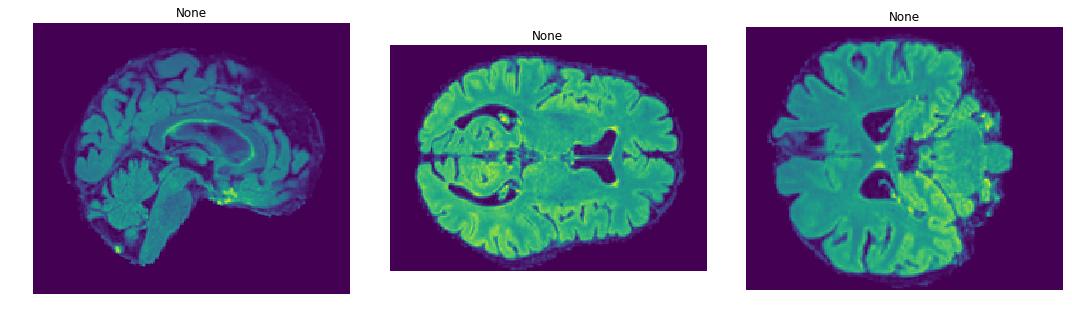

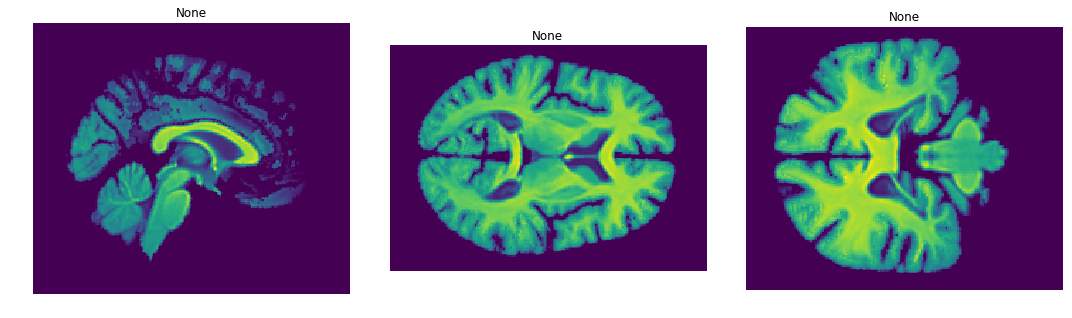

(<matplotlib.figure.Figure at 0x7faee2f95e10>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7faee2ea7c50>,
       dtype=object))

In [120]:
print(patient_id)
t2_atlas = nib.load(t2_final_filename).get_data() # this gives you a LxWxH volume
t2_seg = nib.load(t2_final_seg_filename).get_data()
t1_atlas = nib.load('../t1_atlas.nii').get_data()

slices([t2_atlas[80, :, :], t2_atlas[:, 90, :], t2_atlas[:, :, 90]])
# slices([t2_seg[80, :, :], t2_seg[:, 90, :], t2_seg[:, :, 90]])
slices([t1_atlas[80, :, :], t1_atlas[:, 90, :], t1_atlas[:, :, 90]])

032_S_4277


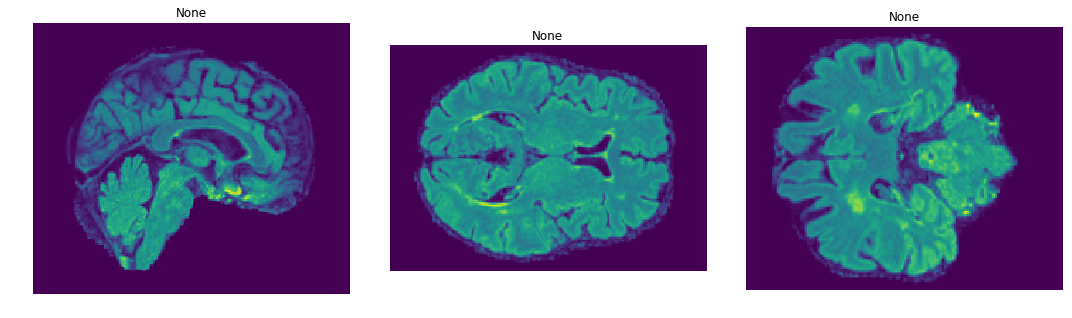

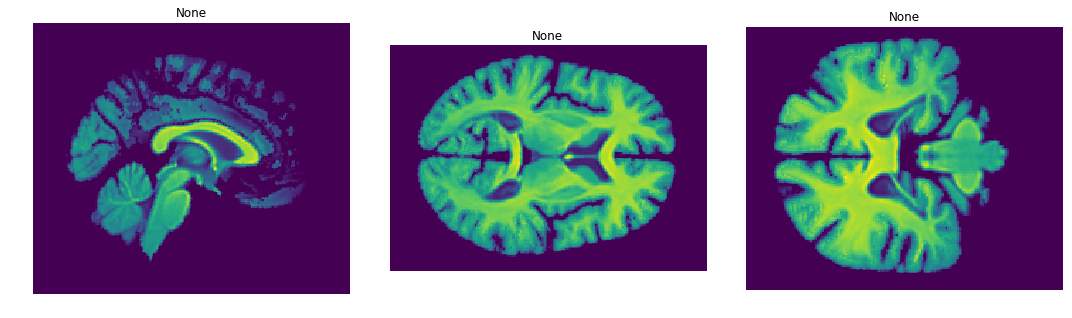

(<matplotlib.figure.Figure at 0x7faee391d390>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7faee31d29b0>,
       dtype=object))

In [109]:
print(patient_id)
t2_atlas = nib.load(t2_final_filename).get_data() # this gives you a LxWxH volume
t2_seg = nib.load(t2_final_seg_filename).get_data()
t1_atlas = nib.load('../t1_atlas.nii').get_data()

slices([t2_atlas[80, :, :], t2_atlas[:, 90, :], t2_atlas[:, :, 90]])
# slices([t2_seg[80, :, :], t2_seg[:, 90, :], t2_seg[:, :, 90]])
slices([t1_atlas[80, :, :], t1_atlas[:, 90, :], t1_atlas[:, :, 90]])

027_S_4919


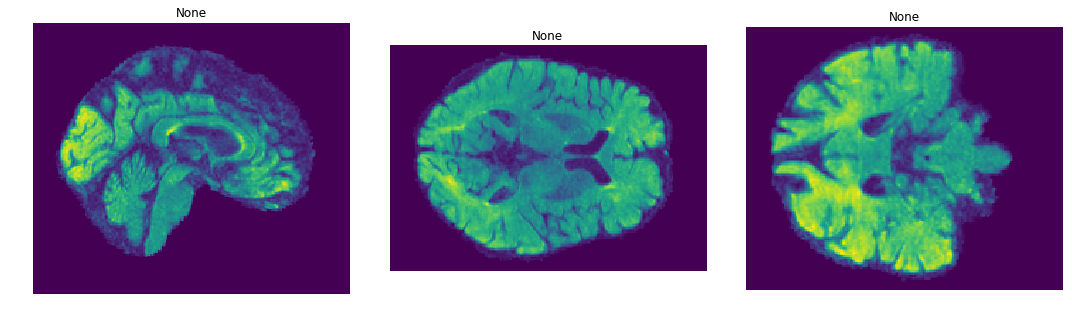

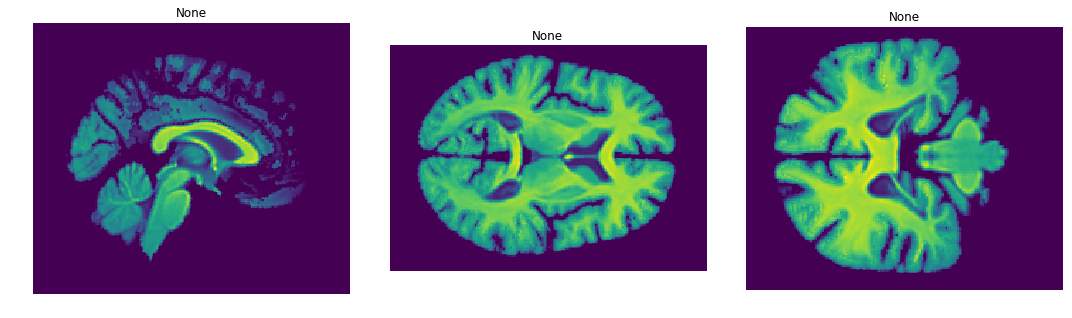

(<matplotlib.figure.Figure at 0x7faee3396c18>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7faee32c0748>,
       dtype=object))

In [98]:
print(patient_id)
t2_atlas = nib.load(t2_final_filename).get_data() # this gives you a LxWxH volume
t2_seg = nib.load(t2_final_seg_filename).get_data()
t1_atlas = nib.load('../t1_atlas.nii').get_data()

slices([t2_atlas[80, :, :], t2_atlas[:, 90, :], t2_atlas[:, :, 90]])
# slices([t2_seg[80, :, :], t2_seg[:, 90, :], t2_seg[:, :, 90]])
slices([t1_atlas[80, :, :], t1_atlas[:, 90, :], t1_atlas[:, :, 90]])

027_S_4869


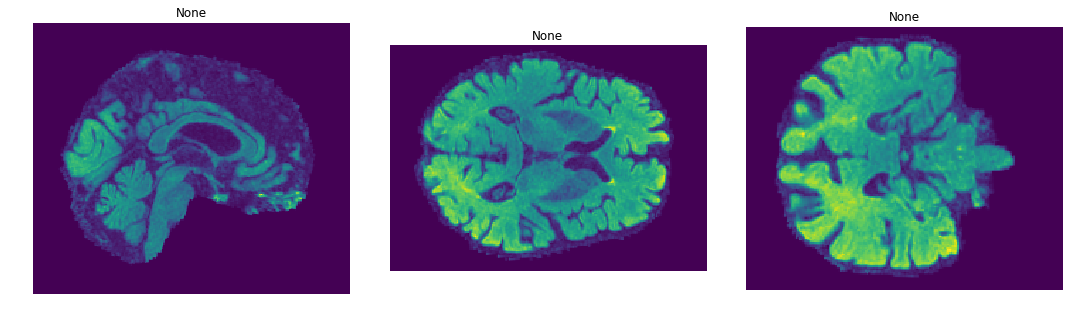

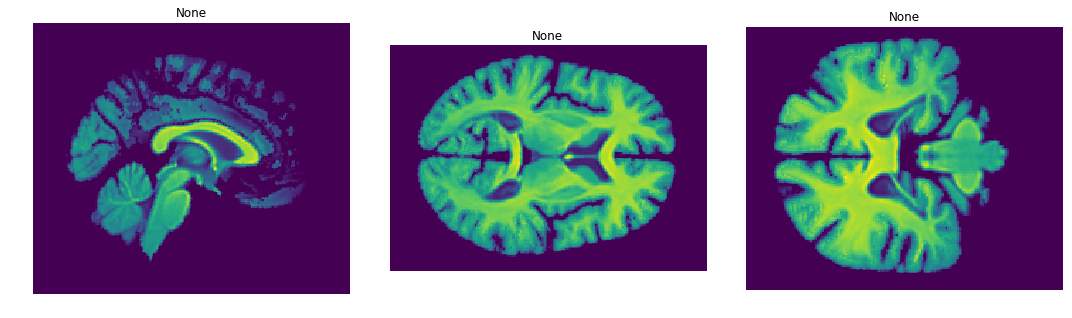

(<matplotlib.figure.Figure at 0x7faee3344358>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7faee32a4198>,
       dtype=object))

In [87]:
print(patient_id)
t2_atlas = nib.load(t2_final_filename).get_data() # this gives you a LxWxH volume
t2_seg = nib.load(t2_final_seg_filename).get_data()
t1_atlas = nib.load('../t1_atlas.nii').get_data()

slices([t2_atlas[80, :, :], t2_atlas[:, 90, :], t2_atlas[:, :, 90]])
# slices([t2_seg[80, :, :], t2_seg[:, 90, :], t2_seg[:, :, 90]])
slices([t1_atlas[80, :, :], t1_atlas[:, 90, :], t1_atlas[:, :, 90]])

027_S_2245


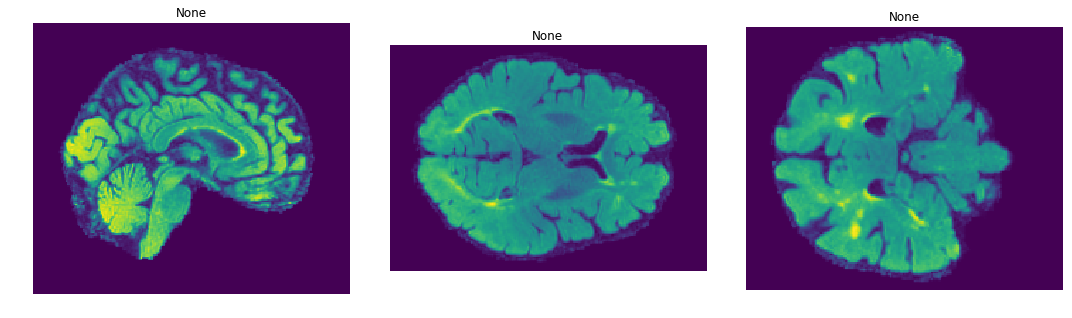

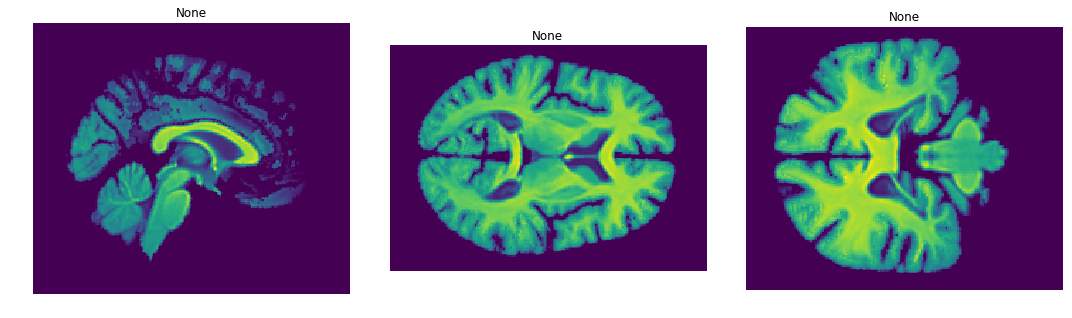

(<matplotlib.figure.Figure at 0x7faee3a7cb70>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7faee36de278>,
       dtype=object))

In [76]:
print(patient_id)
t2_atlas = nib.load(t2_final_filename).get_data() # this gives you a LxWxH volume
t2_seg = nib.load(t2_final_seg_filename).get_data()
t1_atlas = nib.load('../t1_atlas.nii').get_data()

slices([t2_atlas[80, :, :], t2_atlas[:, 90, :], t2_atlas[:, :, 90]])
# slices([t2_seg[80, :, :], t2_seg[:, 90, :], t2_seg[:, :, 90]])
slices([t1_atlas[80, :, :], t1_atlas[:, 90, :], t1_atlas[:, :, 90]])

141_S_1052


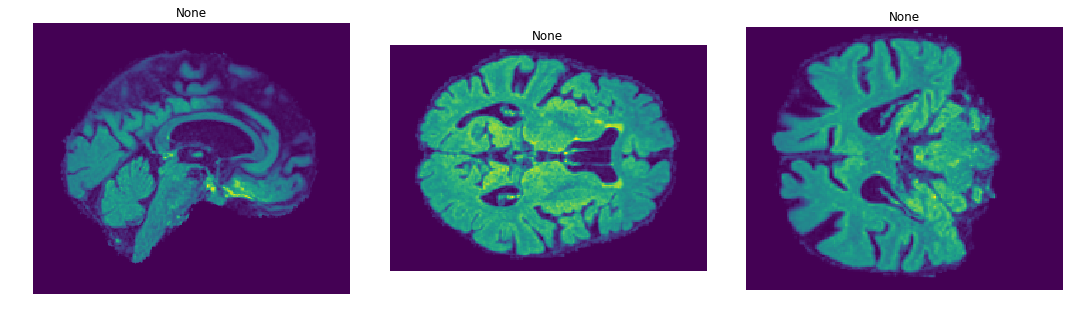

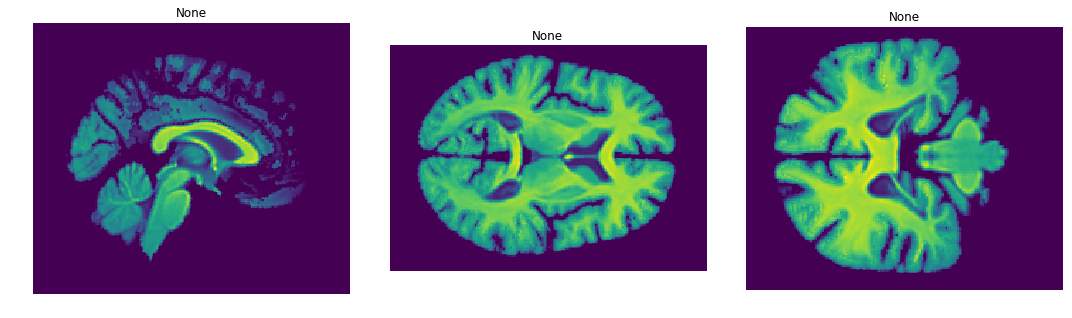

(<matplotlib.figure.Figure at 0x7faee299f588>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7faee36d4ac8>,
       dtype=object))

In [63]:
print('141_S_1052')
t2_atlas = nib.load('../t2_atlas_warped.nii').get_data() # this gives you a LxWxH volume
# t2_seg = nib.load(t2_final_seg_filename).get_data()
t1_atlas = nib.load('../t1_atlas.nii').get_data()

slices([t2_atlas[80, :, :], t2_atlas[:, 90, :], t2_atlas[:, :, 90]])
# slices([t2_seg[80, :, :], t2_seg[:, 90, :], t2_seg[:, :, 90]])
slices([t1_atlas[80, :, :], t1_atlas[:, 90, :], t1_atlas[:, :, 90]])

027_S_2219


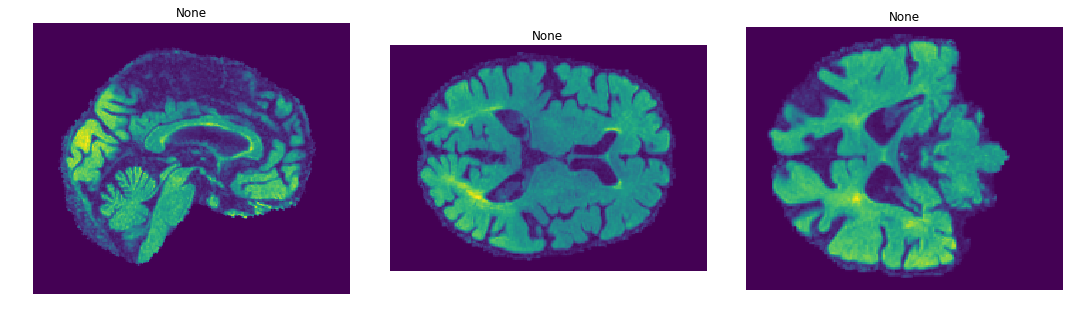

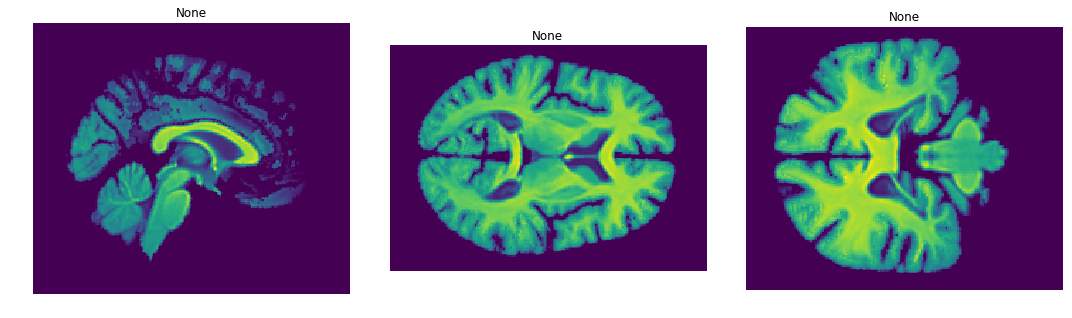

(<matplotlib.figure.Figure at 0x7faee28452e8>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7faee39ca470>,
       dtype=object))

In [61]:
print(patient_id)
t2_atlas = nib.load(t2_final_filename).get_data() # this gives you a LxWxH volume
t2_seg = nib.load(t2_final_seg_filename).get_data()
t1_atlas = nib.load('../t1_atlas.nii').get_data()

slices([t2_atlas[80, :, :], t2_atlas[:, 90, :], t2_atlas[:, :, 90]])
# slices([t2_seg[80, :, :], t2_seg[:, 90, :], t2_seg[:, :, 90]])
slices([t1_atlas[80, :, :], t1_atlas[:, 90, :], t1_atlas[:, :, 90]])

019_S_4293


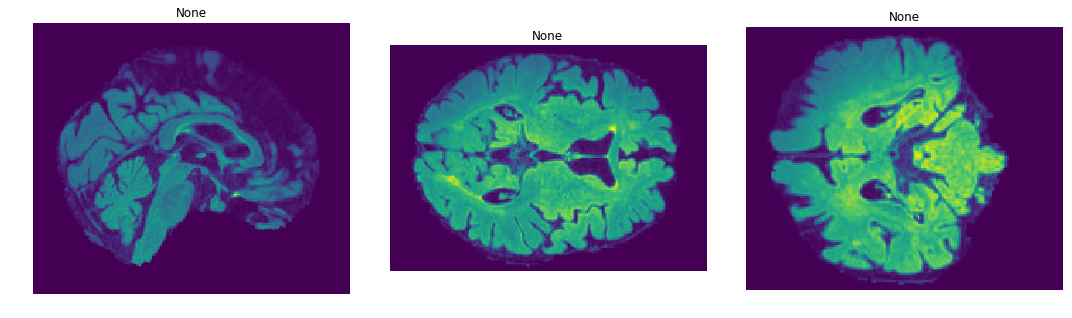

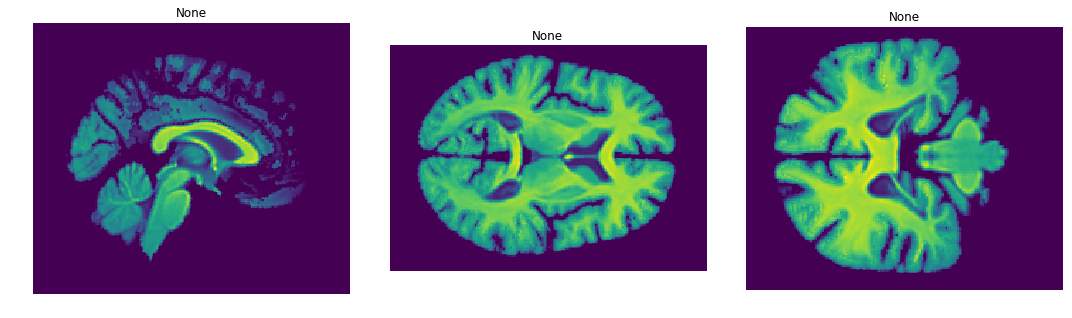

(<matplotlib.figure.Figure at 0x7faeda4bf588>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7faee386e128>,
       dtype=object))

In [47]:
print(patient_id)
t2_atlas = nib.load(t2_final_filename).get_data() # this gives you a LxWxH volume
t2_seg = nib.load(t2_final_seg_filename).get_data()
t1_atlas = nib.load('../t1_atlas.nii').get_data()

slices([t2_atlas[80, :, :], t2_atlas[:, 90, :], t2_atlas[:, :, 90]])
# slices([t2_seg[80, :, :], t2_seg[:, 90, :], t2_seg[:, :, 90]])
slices([t1_atlas[80, :, :], t1_atlas[:, 90, :], t1_atlas[:, :, 90]])

018_S_2155


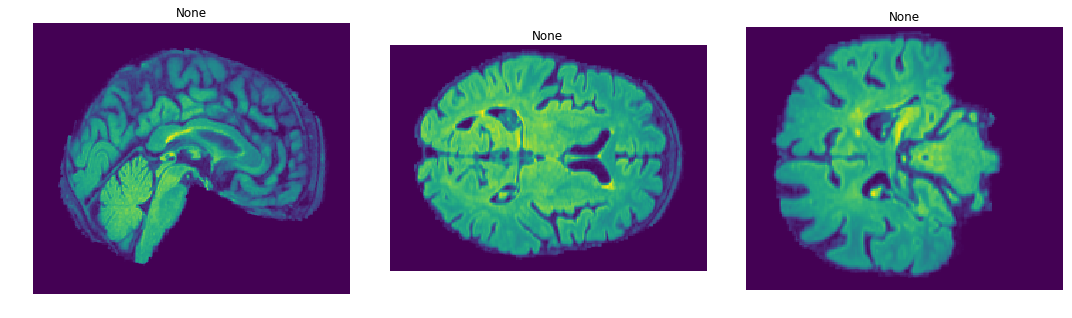

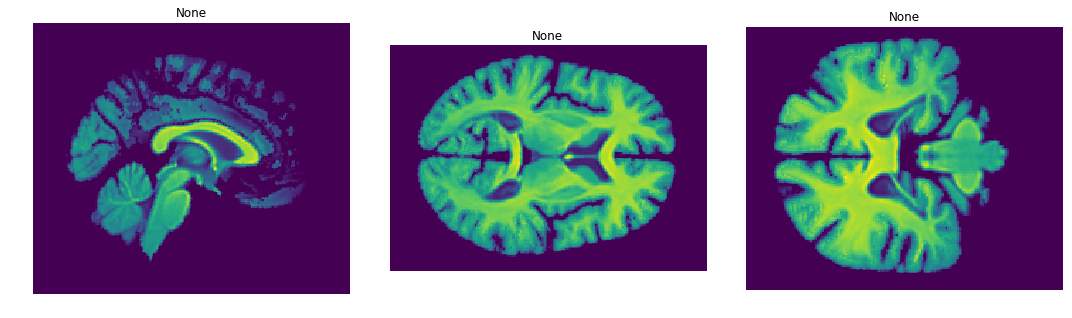

(<matplotlib.figure.Figure at 0x7faee28a4390>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7faee3139a58>,
       dtype=object))

In [36]:
print(patient_id)
t2_atlas = nib.load(t2_final_filename).get_data() # this gives you a LxWxH volume
t2_seg = nib.load(t2_final_seg_filename).get_data()
t1_atlas = nib.load('../t1_atlas.nii').get_data()

slices([t2_atlas[80, :, :], t2_atlas[:, 90, :], t2_atlas[:, :, 90]])
# slices([t2_seg[80, :, :], t2_seg[:, 90, :], t2_seg[:, :, 90]])
slices([t1_atlas[80, :, :], t1_atlas[:, 90, :], t1_atlas[:, :, 90]])

009_S_0751


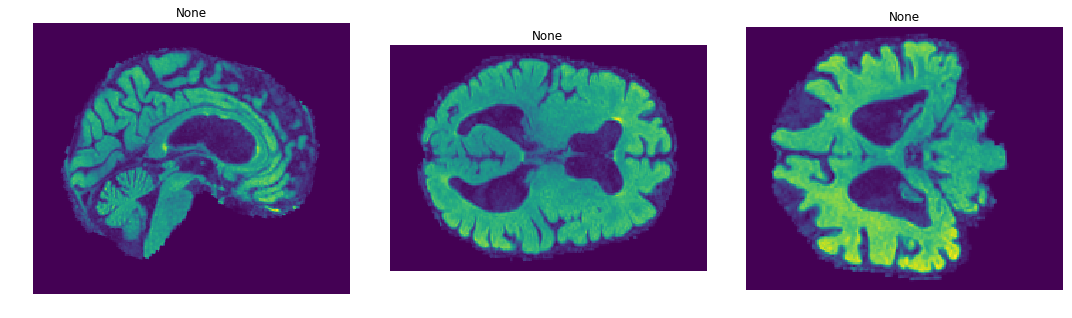

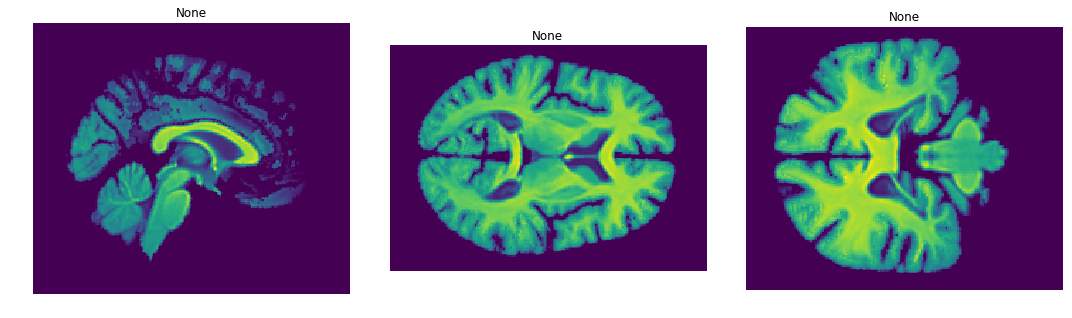

(<matplotlib.figure.Figure at 0x7faee29b9e10>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7faee2814cf8>,
       dtype=object))

In [25]:
print(patient_id)
t2_atlas = nib.load(t2_final_filename).get_data() # this gives you a LxWxH volume
t2_seg = nib.load(t2_final_seg_filename).get_data()
t1_atlas = nib.load('../t1_atlas.nii').get_data()

slices([t2_atlas[80, :, :], t2_atlas[:, 90, :], t2_atlas[:, :, 90]])
# slices([t2_seg[80, :, :], t2_seg[:, 90, :], t2_seg[:, :, 90]])
slices([t1_atlas[80, :, :], t1_atlas[:, 90, :], t1_atlas[:, :, 90]])

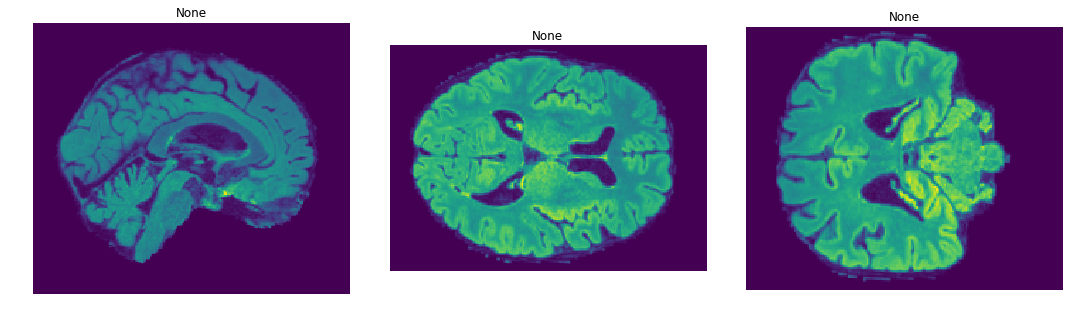

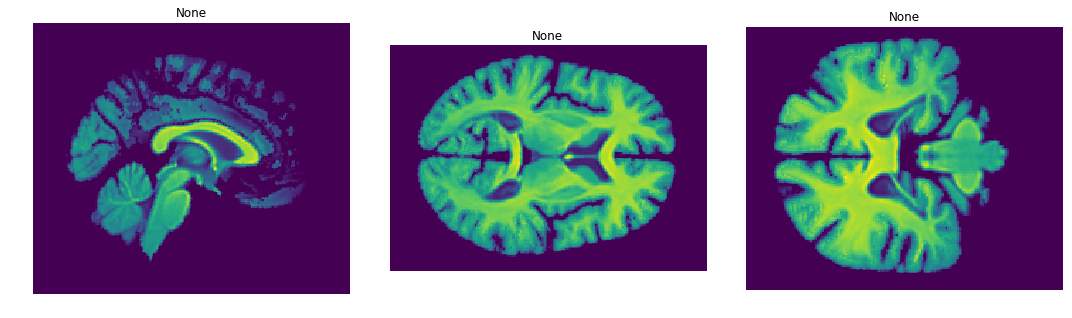

(<matplotlib.figure.Figure at 0x7faee3ced7b8>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7faee3a86358>,
       dtype=object))

In [13]:
print(patient_id)
t2_atlas = nib.load(t2_final_filename).get_data() # this gives you a LxWxH volume
t2_seg = nib.load(t2_final_seg_filename).get_data()
t1_atlas = nib.load('../t1_atlas.nii').get_data()

slices([t2_atlas[80, :, :], t2_atlas[:, 90, :], t2_atlas[:, :, 90]])
# slices([t2_seg[80, :, :], t2_seg[:, 90, :], t2_seg[:, :, 90]])
slices([t1_atlas[80, :, :], t1_atlas[:, 90, :], t1_atlas[:, :, 90]])

In [125]:
t2_atlas = nib.load('../t2_atlas_027_S_2219.nii').get_data() # this gives you a LxWxH volume
np.histogram(t2_atlas)

103.955345

(array([5134105,  311162,  158522,  221931,  654391,  357163,   39970,
           3539,     452,      45]),
 array([   0.        ,  101.5345459 ,  203.0690918 ,  304.6036377 ,
         406.13818359,  507.67272949,  609.20727539,  710.74182129,
         812.27636719,  913.81091309, 1015.34545898]))

In [128]:
t2_atlas = nib.load('../t2_atlas_032_S_5289.nii').get_data() # this gives you a LxWxH volume
np.histogram(t2_atlas)

(array([5106398,  186090,  860729,  685228,   41498,     996,     246,
             67,      23,       5]),
 array([  0.        ,  24.8019516 ,  49.6039032 ,  74.4058548 ,
         99.2078064 , 124.009758  , 148.81170959, 173.61366119,
        198.41561279, 223.21756439, 248.01951599]))

In [130]:
t2_atlas = nib.load('../t2_atlas_warped.nii').get_data() # this gives you a LxWxH volume
np.histogram(t2_atlas)
np.max(t2_atlas/np.max(t2_atlas))

1.0